In [1]:
from financetoolkit import Toolkit
from creds import api_key

companies = Toolkit(['MSFT'], api_key=api_key, start_date='2006-01-03', end_date='2017-12-04')

historical_data = companies.get_historical_data()

historical_data.tail()

,Adj Close,Close,Cumulative Return,Dividends,High,Low,Open,Return,Volume
Date,,,,,,,,,
2017-11-27,78.446373,83.870003,3.121676,0.0,83.980003,83.300003,83.309998,0.007327,18265200
2017-11-28,79.391052,84.879997,3.171311,0.0,85.059998,84.019997,84.070000,0.012042,21926000
2017-11-29,77.950623,83.339996,3.095629,0.0,84.919998,83.180000,84.709999,-0.018143,27381100
2017-11-30,78.726959,84.169998,3.136418,0.0,84.519997,83.339996,83.510002,0.009959,33054600
2017-12-01,78.811134,84.260002,3.140841,0.0,84.809998,83.220001,83.599998,0.001069,29532100


In [2]:
from sklearn.preprocessing import MinMaxScaler

price = historical_data[['Adj Close']].copy()
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Adj Close'] = scaler.fit_transform(price['Adj Close'].values.reshape(-1,1))

price.head(20)

,Adj Close
Date,
2006-01-03,-0.773592
2006-01-04,-0.770883
2006-01-05,-0.770466
2006-01-06,-0.772133
2006-01-09,-0.773175
2006-01-10,-0.770258
2006-01-11,-0.764215
2006-01-12,-0.767341
2006-01-13,-0.766298


In [3]:
import numpy as np

def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    

    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [4]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [5]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [6]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.h0 = nn.Parameter(torch.zeros(self.num_layers, 1, self.hidden_dim))

    def forward(self, x):
        h0 = self.h0.expand(self.num_layers, x.size(0), self.hidden_dim)
        
        out, (hn) = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [7]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
gru = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.6687414646148682
Epoch  1 MSE:  0.2779272198677063
Epoch  2 MSE:  0.08537227660417557
Epoch  3 MSE:  0.02779499441385269
Epoch  4 MSE:  0.09621972590684891
Epoch  5 MSE:  0.07932087779045105
Epoch  6 MSE:  0.03549306467175484
Epoch  7 MSE:  0.03008122555911541
Epoch  8 MSE:  0.04796574264764786
Epoch  9 MSE:  0.05928365886211395
Epoch  10 MSE:  0.05544420704245567
Epoch  11 MSE:  0.042476654052734375
Epoch  12 MSE:  0.02957437001168728
Epoch  13 MSE:  0.023825326934456825
Epoch  14 MSE:  0.026877809315919876
Epoch  15 MSE:  0.03317981958389282
Epoch  16 MSE:  0.034472569823265076
Epoch  17 MSE:  0.02878289669752121
Epoch  18 MSE:  0.021397415548563004
Epoch  19 MSE:  0.01769906096160412
Epoch  20 MSE:  0.018534444272518158
Epoch  21 MSE:  0.021008607000112534
Epoch  22 MSE:  0.021510357037186623
Epoch  23 MSE:  0.018391501158475876
Epoch  24 MSE:  0.013028563931584358
Epoch  25 MSE:  0.008855369873344898
Epoch  26 MSE:  0.008505268953740597
Epoch  27 MSE:  0.0102352788

In [9]:
import pandas as pd

predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

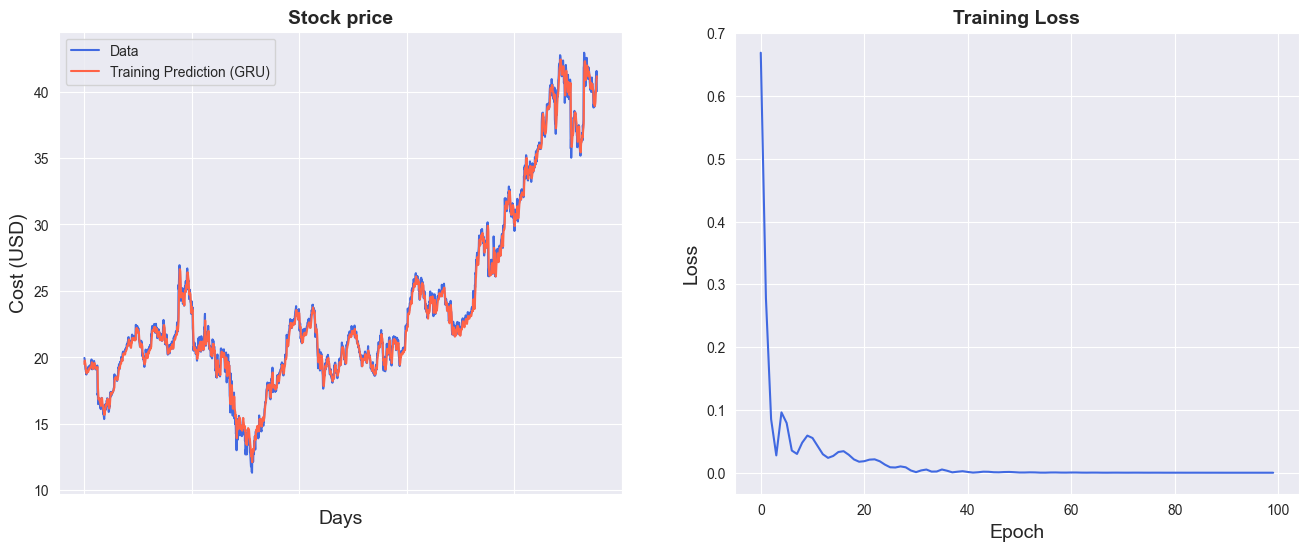

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (GRU)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [11]:
import math
from sklearn.metrics import mean_squared_error

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.47 RMSE
Test Score: 3.82 RMSE


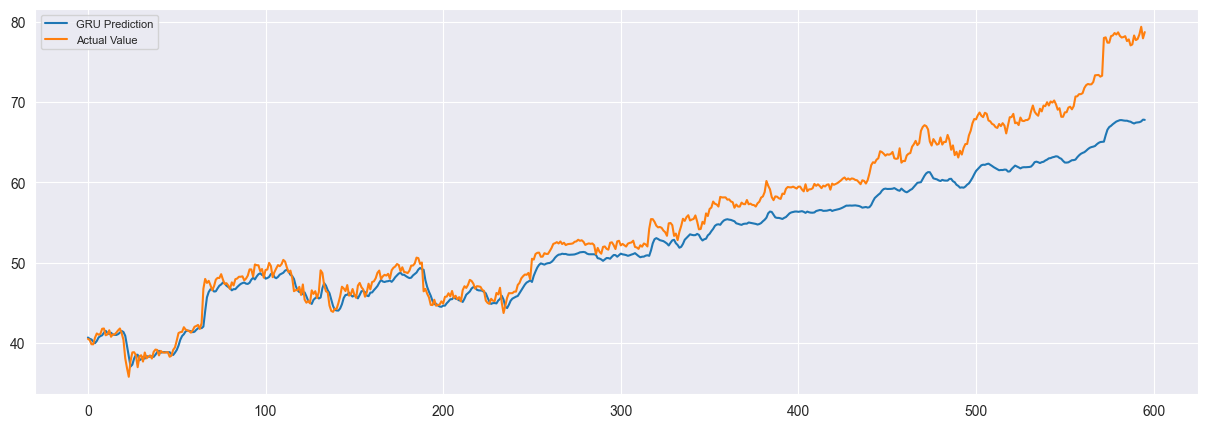

In [12]:
import matplotlib.pyplot as plt2
plt2.figure(figsize=(15, 5))
plt2.plot(y_test_pred, label='GRU Prediction')
plt2.plot(y_test, label='Actual Value')
plt2.legend(loc='upper left', fontsize=8)
plt2.show()